## **Customer Churn Prediction - Logistic Regression Modeling**

This is a notebook with the notes taken from the [Machine Learning Zoomcamp](https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp), based on the book **"Machine Learning Bookcamp"** written by Alexey Grigorev.

In [74]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from IPython.display import display

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Magic function to display matplotlib figures in a jupyter notebook
%matplotlib inline

# Display dataset
pd.options.display.max_columns = 50


In [2]:
data = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
len(data)

7043

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## **Data Pre-processing**

In [5]:
# Converting TotalCharges column values to numeric
total_charges = pd.to_numeric(data["TotalCharges"], errors="coerce")    # coerce to force convertion of strings " " into NaN
data[total_charges.isnull()][["customerID", "TotalCharges"]]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


In [6]:
# Setting missing values to zero
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")
data["TotalCharges"] = data["TotalCharges"].fillna(0)

### Standarizing column names and values

In [7]:
data.columns = data.columns.str.lower().str.replace(" ", "_")
data.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [8]:
string_columns = list(data.dtypes[data.dtypes == "object"].index)
for col in string_columns:
    data[col] = data[col].str.lower().str.replace(" ", "_")

data.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [9]:
# Looking into target variable
data["churn"].head()

0     no
1     no
2    yes
3     no
4    yes
Name: churn, dtype: object

In [10]:
data["churn"].unique()

array(['no', 'yes'], dtype=object)

In [11]:
# Changing yes/no for 1/0
data["churn"] = data["churn"].apply(lambda x: 1 if x == "yes" else 0)
data["churn"]

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: churn, Length: 7043, dtype: int64

In [12]:
# Splitting data into training and testing subsets
df_train_full, df_test = train_test_split(data, test_size=0.2, random_state=1)

In [13]:
df_train_full.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,yes,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,yes,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,no,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
3676,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,yes,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [14]:
# Obtaining the validation subset
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

# Defining target variables for each subset
y_train = df_train["churn"].values
y_val = df_val["churn"].values

# Deleting the target variables from subsets to avoid perfect fitting
del df_train["churn"]
del df_val["churn"]

## **Exploratory Data Analysis (EDA)**

In [15]:
# Checking for missing values in full training dataset
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

No missing values to handle!

In [16]:
# Checking the distribution of values in the target variable
df_train_full["churn"].value_counts()

0    4113
1    1521
Name: churn, dtype: int64

In [17]:
# Estimating churn rate
global_cr = df_train_full["churn"].mean()
print("The churn rate is =", np.round(global_cr, 3))

The churn rate is = 0.27


In [18]:
categorical = [
    "gender", "seniorcitizen", "partner",
    "dependents", "phoneservice", "multiplelines",
    "internetservice", "onlinesecurity", "onlinebackup",
    "deviceprotection", "techsupport", "streamingtv",
    "streamingmovies", "contract", "paperlessbilling",
    "paymentmethod"
]

numerical = ["tenure", "monthlycharges", "totalcharges"]

In [19]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### **Feature Importance**

In [20]:
# Churn rate by gender
female_cr = df_train_full[df_train_full["gender"] == "female"]["churn"].mean()
male_cr = df_train_full[df_train_full["gender"] == "male"]["churn"].mean()
print("Global churn rate: ", np.round(global_cr, 4))
print("Female churn rate: ", np.round(female_cr, 4))
print("Male churn rate: ", np.round(male_cr, 4))

Global churn rate:  0.27
Female churn rate:  0.2768
Male churn rate:  0.2632


There's no much difference between them

In [21]:
# Churn rate by having partner
partner_yes_cr = df_train_full[df_train_full["partner"] == "yes"]["churn"].mean()
partner_no_cr = df_train_full[df_train_full["partner"] == "no"]["churn"].mean()
print("Global churn rate: ", np.round(global_cr, 4))
print("with partner:", np.round(partner_yes_cr, 4))
print("without partner:", np.round(partner_no_cr, 4))

Global churn rate:  0.27
with partner: 0.205
without partner: 0.3298


The churn rate for people with a partner is considerably less than the rate for the ones without a partner which indicates that the `partner` variable is usefull for predicting churn.

Another interesting way to look for the posibility of customers to churn is to calculate the risk ratio. 

Risk ratio = Group rate / Global rate

If the risk ratio is lower than 1, the group has a lower risk of churning. If the risk is higher than 1, the group has a larger risk of churning. If it's close to one, the risk is almost none.

In [22]:
# Calculating the risk of churning (Risk ratio = Group rate / Global rate)
df_group = df_train_full.groupby("gender")["churn"].agg(["mean"])
df_group["diff"] = df_group["mean"] - global_cr
df_group["risk"] = df_group["mean"] / global_cr
df_group

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


In [23]:
# For al categorical variables
for col in categorical:
    df_group = df_train_full.groupby(by=col)["churn"].agg(["mean"])
    df_group["diff"] = df_group["mean"] - global_cr
    df_group["risk"] = df_group["mean"] / global_cr
    display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


In [24]:
# Calculating the Mutual information score
def calculate_mi(series):
    return mutual_info_score(series, df_train_full["churn"])

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


In [25]:
# Calculating the correlation coefficient for the numerical variables
df_train_full[numerical].corrwith(df_train_full["churn"])

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [26]:
tenure_cr_0_2 = np.round(df_train_full[df_train_full["tenure"] <= 2]["churn"].mean(), 3)
tenure_cr_3_12 = np.round(df_train_full[(df_train_full["tenure"] > 2) & (df_train_full["tenure"] <= 12)]["churn"].mean(), 3)
tenure_cr_more = np.round(df_train_full[df_train_full["tenure"] > 12]["churn"].mean(), 3)
print("Churn rate for customers staying 2 months or less       = {}".format(tenure_cr_0_2))
print("Churn rate for customers staying between 3 to 12 months = {}".format(tenure_cr_3_12))
print("Churn rate for customers staying more than a year       = {}".format(tenure_cr_more))

Churn rate for customers staying 2 months or less       = 0.595
Churn rate for customers staying between 3 to 12 months = 0.399
Churn rate for customers staying more than a year       = 0.176


In [27]:
month_charges_cr_0_20 = np.round(df_train_full[df_train_full["monthlycharges"] <= 20]["churn"].mean(), 3)
month_charges_cr_21_50 = np.round(df_train_full[(df_train_full["monthlycharges"] > 20) & (df_train_full["monthlycharges"] <= 50)]["churn"].mean(), 3)
month_charges_cr_more = np.round(df_train_full[df_train_full["monthlycharges"] > 50]["churn"].mean(), 3)
print("Churn rate for customers paying $20 or less                     = {}".format(month_charges_cr_0_20))
print("Churn rate for customers paying more than $20 and less than $50 = {}".format(month_charges_cr_21_50))
print("Churn rate for customers paying more than $50                   = {}".format(month_charges_cr_more))

Churn rate for customers paying $20 or less                     = 0.088
Churn rate for customers paying more than $20 and less than $50 = 0.183
Churn rate for customers paying more than $50                   = 0.325


In [28]:
total_charges_cr_0_2k = np.round(df_train_full[df_train_full["totalcharges"] <= 2000]["churn"].mean(), 3)
total_charges_cr_2k_5k = np.round(df_train_full[(df_train_full["totalcharges"] > 2000) & (df_train_full["totalcharges"] <= 5000)]["churn"].mean(), 3)
total_charges_cr_more = np.round(df_train_full[df_train_full["totalcharges"] > 5000]["churn"].mean(), 3)
print("Churn rate for customers paying $20 or less                     = {}".format(total_charges_cr_0_2k))
print("Churn rate for customers paying more than $20 and less than $50 = {}".format(total_charges_cr_2k_5k))
print("Churn rate for customers paying more than $50                   = {}".format(total_charges_cr_more))

Churn rate for customers paying $20 or less                     = 0.324
Churn rate for customers paying more than $20 and less than $50 = 0.223
Churn rate for customers paying more than $50                   = 0.143


- Customers with lower tenures tend to churn more.
- Customers paying higher monthly fees tend to churn more.
- Customers paying lower total amounts tend to churn more.

### **Feature Engineering**

One hot encoding

In [29]:
train_df = df_train[categorical + numerical].to_dict(orient="records")
train_df[0]

{'gender': 'male',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'dsl',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'bank_transfer_(automatic)',
 'tenure': 71,
 'monthlycharges': 86.1,
 'totalcharges': 6045.9}

In [30]:
# Vectorizing the dictionary
dv = DictVectorizer(sparse=False)
dv.fit(train_df)

DictVectorizer(sparse=False)

In [31]:
X_train = dv.transform(train_df)
X_train[0]

array([0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 8.6100e+01, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 7.1000e+01, 6.0459e+03])

In [32]:
dv.get_feature_names()

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'dependents=no',
 'dependents=yes',
 'deviceprotection=no',
 'deviceprotection=no_internet_service',
 'deviceprotection=yes',
 'gender=female',
 'gender=male',
 'internetservice=dsl',
 'internetservice=fiber_optic',
 'internetservice=no',
 'monthlycharges',
 'multiplelines=no',
 'multiplelines=no_phone_service',
 'multiplelines=yes',
 'onlinebackup=no',
 'onlinebackup=no_internet_service',
 'onlinebackup=yes',
 'onlinesecurity=no',
 'onlinesecurity=no_internet_service',
 'onlinesecurity=yes',
 'paperlessbilling=no',
 'paperlessbilling=yes',
 'partner=no',
 'partner=yes',
 'paymentmethod=bank_transfer_(automatic)',
 'paymentmethod=credit_card_(automatic)',
 'paymentmethod=electronic_check',
 'paymentmethod=mailed_check',
 'phoneservice=no',
 'phoneservice=yes',
 'seniorcitizen',
 'streamingmovies=no',
 'streamingmovies=no_internet_service',
 'streamingmovies=yes',
 'streamingtv=no',
 'streamingtv=no_internet_servic

We've just created columns for each categorical value. For example, for **contract** we have a column for `month-to-month`, `one_year` and `two_year` values.

### **Machine Learning for classification**

Logistic Regression

In [33]:
model = LogisticRegression(solver="liblinear", random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

Validating the model

In [34]:
val_dict = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dict)

In [35]:
y_pred = model.predict_proba(X_val)[:, 1] # Soft prediction
y_pred

array([0.23490548, 0.26885036, 0.31944932, ..., 0.05724868, 0.6152276 ,
       0.06127278])

Setting a Threshold for churn customers

In [36]:
churn = y_pred >= 0.5 # Hard prediction

Evaluating the quality (*accuracy*) of the predictions

In [37]:
(y_val == churn).mean()

0.8016129032258065

Model Interpretation

In [38]:
model.intercept_[0] # Bias term

-0.12198811467233629

In [39]:
model.coef_[0] # Coeefficients

array([ 5.63364001e-01, -8.58801191e-02, -5.99471996e-01, -3.02653696e-02,
       -9.17227451e-02,  9.99351394e-02, -1.15874933e-01, -1.06048321e-01,
       -2.73672166e-02, -9.46208981e-02, -3.23337975e-01,  3.17224794e-01,
       -1.15874933e-01,  7.83699338e-04, -1.68108194e-01,  1.27129027e-01,
       -8.10089474e-02,  1.35691087e-01, -1.15874933e-01, -1.41804269e-01,
        2.57837939e-01, -1.15874933e-01, -2.63951121e-01, -2.12622849e-01,
        9.06347345e-02, -4.79899461e-02, -7.39981686e-02, -2.66727814e-02,
       -1.36238321e-01,  1.74728722e-01, -1.33805734e-01,  1.27129027e-01,
       -2.49117141e-01,  2.97084094e-01, -8.48297478e-02, -1.15874933e-01,
        7.87165660e-02, -9.90472114e-02, -1.15874933e-01,  9.29340297e-02,
        1.78129406e-01, -1.15874933e-01, -1.84242588e-01, -6.94882832e-02,
        4.47713249e-04])

In [40]:
dict(zip(dv.get_feature_names(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.563,
 'contract=one_year': -0.086,
 'contract=two_year': -0.599,
 'dependents=no': -0.03,
 'dependents=yes': -0.092,
 'deviceprotection=no': 0.1,
 'deviceprotection=no_internet_service': -0.116,
 'deviceprotection=yes': -0.106,
 'gender=female': -0.027,
 'gender=male': -0.095,
 'internetservice=dsl': -0.323,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.116,
 'monthlycharges': 0.001,
 'multiplelines=no': -0.168,
 'multiplelines=no_phone_service': 0.127,
 'multiplelines=yes': -0.081,
 'onlinebackup=no': 0.136,
 'onlinebackup=no_internet_service': -0.116,
 'onlinebackup=yes': -0.142,
 'onlinesecurity=no': 0.258,
 'onlinesecurity=no_internet_service': -0.116,
 'onlinesecurity=yes': -0.264,
 'paperlessbilling=no': -0.213,
 'paperlessbilling=yes': 0.091,
 'partner=no': -0.048,
 'partner=yes': -0.074,
 'paymentmethod=bank_transfer_(automatic)': -0.027,
 'paymentmethod=credit_card_(automatic)': -0.136,
 'paymentmethod=electronic_check': 0.175,


In [41]:
small_subset = ["contract", "tenure", "totalcharges"]
train_dict_small = df_train[small_subset].to_dict(orient="records")
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)
X_small_train = dv_small.transform(train_dict_small)

In [42]:
dv_small.get_feature_names()

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'tenure',
 'totalcharges']

In [43]:
model_small = LogisticRegression(solver="liblinear", random_state=1)
model_small.fit(X_small_train, y_train)
print("Bias (intercept) term:", model_small.intercept_[0])
print("Coefficients:", dict(zip(dv_small.get_feature_names(), model_small.coef_[0].round(3))))

Bias (intercept) term: -0.5772299133614702
Coefficients: {'contract=month-to-month': 0.866, 'contract=one_year': -0.327, 'contract=two_year': -1.117, 'tenure': -0.094, 'totalcharges': 0.001}


Making a prediction

In [44]:
customer = {
    "customerid": "8879-zkjof",
    "gender": "female",
    "seniorcitizen": 0,
    "partner": "no",
    "dependents": "no",
    "tenure": 41,
    "phoneservice": "yes",
    "multiplelines": "no",
    "internetservice": "dsl",
    "onlinesecurity": "yes",
    "onlinebackup": "no",
    "deviceprotection": "yes",
    "techsupport": "yes",
    "streamingtv": "yes",
    "streamingmovies": "yes",
    "contract": "one_year",
    "paperlessbilling": "yes",
    "paymentmethod": "bank_transfer_(automatic)",
    "monthlycharges": 79.85,
    "totalcharges": 3320.75
}

In [45]:
X_test = dv.transform([customer])
X_test

array([[0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 7.98500e+01, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 4.10000e+01, 3.32075e+03]])

In [46]:
model.predict_proba(X_test)[0, 1]

0.07332577315357781

The probablity that this customer will churn is only 7%. Since it's less than 50%, this customer would not receive a promotional email.

In [47]:
customer2 = {
    "gender": "female",
    "seniorcitizen": 1,
    "partner": "no",
    "dependents": "no",
    "tenure": 1,
    "phoneservice": "yes",
    "multiplelines": "yes",
    "internetservice": "fiber_optic",
    "onlinesecurity": "no",
    "onlinebackup": "no",
    "deviceprotection": "no",
    "techsupport": "no",
    "streamingtv": "yes",
    "streamingmovies": "no",
    "contract": "month-to-month",
    "paperlessbilling": "yes",
    "paymentmethod": "electronic_check",
    "monthlycharges": 85.7,
    "totalcharges": 85.7
}

In [48]:
X_test = dv.transform([customer2])
X_test

array([[ 1. ,  0. ,  0. ,  1. ,  0. ,  1. ,  0. ,  0. ,  1. ,  0. ,  0. ,
         1. ,  0. , 85.7,  0. ,  0. ,  1. ,  1. ,  0. ,  0. ,  1. ,  0. ,
         0. ,  0. ,  1. ,  1. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  1. ,
         1. ,  1. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  0. ,  0. ,  1. ,
        85.7]])

In [49]:
model.predict_proba(X_test)[0, 1]

0.8321638622459152

The probablity that this customer will churn is 83.22%. This customer should receive a promotional mail in the hope of retaining them.

## **Evaluation Metrics for Classification**

#### **Accuracy**

0.00 0.261
0.10 0.595
0.20 0.690
0.30 0.755
0.40 0.782
0.50 0.802
0.60 0.790
0.70 0.774
0.80 0.742
0.90 0.739
1.00 0.739


Text(0, 0.5, 'Accuracy')

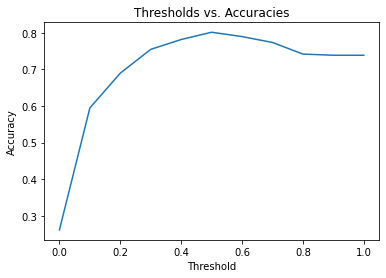

In [50]:
# For various thresholds
thresholds = np.linspace(0, 1, 11)
accuracies = []
for t in thresholds:
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    accuracies.append(acc)
    print("%0.2f %0.3f" % (t, acc))

plt.plot(thresholds, accuracies)
plt.title("Thresholds vs. Accuracies")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")

In [51]:
# Checking the accuracy of the smaller model
val_dict_small = df_val[small_subset].to_dict(orient="records")
X_small_val = dv_small.transform(val_dict_small)
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]
churn_small = y_pred_small >= 0.5
accuracy_score(y_val, churn_small)

0.7672043010752688

The large model accuracy (80%) is 4% more accurate than the small one (76%). However, this still doesn't tell us whether 80% or 76% is a good accuracy.

#### **Dummy Baseline**

In [52]:
# Creating a dummy baseline
size_val = len(y_val)
baseline = np.repeat(False, size_val)
baseline

array([False, False, False, ..., False, False, False])

In [53]:
# Checking the accuracy of the dummy baseline
accuracy_score(baseline, y_val)

0.7387096774193549

As we can see, the small model is only 2% better than the naive baseline and the large one is 6% better.

According to this, the model is only slightly better than a dummy model that treats all the customers as non-churning and doesn't attempt to keep any of them.

#### **Confusion Table**

- **True Negative (TN):**   Predicted value = False (No Churn) and Actual value = False (No Churn).
- **True Positive (TP):**   Predicted value = True (Churn) and Actual value = True (Churn).
- **False Negative (FN):**  Predicted value = False (No Churn) and Actual value = True (Churn).
- **False Positive (FP):**  Predicted value = True (Churn) and Actual value = False (No Churn).

In [54]:
# Calculating the confusion table
t = 0.5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)

actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

true_positive = (predict_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()
false_negative = (predict_no_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

confusion_table = np.array([
    [true_negative, false_positive],
    [false_negative, true_positive]
])

print(confusion_table, "\n")
print(np.round(confusion_table / confusion_table.sum(), 3))

[[1202  172]
 [ 197  289]] 

[[0.646 0.092]
 [0.106 0.155]]


We can see that the models predicts negative values quite well: 65% of predictions are true negatives. However, it makes quite a few mistakes of both types: the number of false positives and false negatives is roughly equal (9% and 11%, respectively).

In [55]:
# Accuracy from confusion table values
accuracy = (true_negative + true_positive) / (true_negative + true_positive + false_negative + false_positive)
accuracy

0.8016129032258065

#### **Precision and Recall**

In [56]:
# Precision: It's the fraction of correctly predicted positive examples
# (Percentage of correct predictions among customers predicted as churning).
precision = true_positive / (true_positive + false_positive)
precision


0.6268980477223427

In [57]:
# Recall: It's the fraction of correctly classified positive examples among all positive examples.
# (Percentage of customers correctly perdicted as churning among all churned customers).
recall = true_positive / (true_positive + false_negative)
recall

0.5946502057613169

#### **ROC curve and AUC score**

In [58]:
# True Positive Rate (TPR): Fraction of customers who were predicted as churning out of customers who actually churned.
# Same as Recall
tpr = true_positive / (true_positive + false_negative)
print("TPR =", tpr)

# False Positive Rate (FPR): Fraction of customers who were predicted as churning out of customers who actually didn't churn.
fpr = false_positive / (false_positive + true_negative)
print("FPR =", fpr)

TPR = 0.5946502057613169
FPR = 0.12518195050946143


In [59]:
# For multiple thresholds
scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ["threshold", "TP", "FP", "FN", "TN"]
df_scores[::10]

,threshold,TP,FP,FN,TN
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


In [60]:
# Computing TPR and FPR
df_scores["TPR"] = df_scores["TP"] / (df_scores["TP"] + df_scores["FN"])
df_scores["FPR"] = df_scores["FP"] / (df_scores["FP"] + df_scores["TN"])
df_scores[::10]

,threshold,TP,FP,FN,TN,TPR,FPR
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


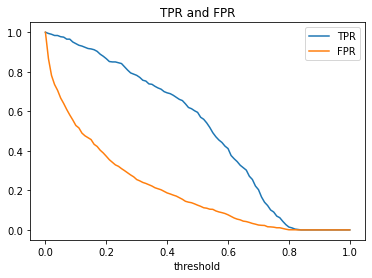

In [61]:
plt.plot(df_scores["threshold"], df_scores["TPR"], label="TPR")
plt.plot(df_scores["threshold"], df_scores["FPR"], label="FPR")
plt.title("TPR and FPR")
plt.xlabel("threshold")
plt.legend()
plt.show()

In [62]:
# Random Baseline Model
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [65]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()
        scores.append((t, tp, fp, fn, tn))
    df_scores = pd.DataFrame(scores)
    df_scores.columns = ["Threshold", "TP", "FP", "FN", "TN"]
    df_scores["TPR"] = df_scores["TP"] / (df_scores["TP"] + df_scores["FN"])
    df_scores["FPR"] = df_scores["FP"] / (df_scores["FP"] + df_scores["TN"])

    return df_scores

In [66]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,Threshold,TP,FP,FN,TN,TPR,FPR
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


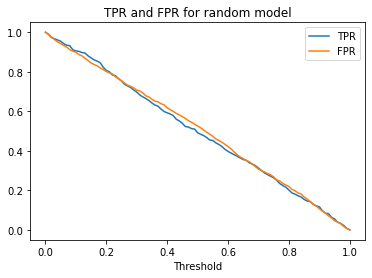

In [68]:
plt.plot(df_rand["Threshold"], df_rand["TPR"], label="TPR")
plt.plot(df_rand["Threshold"], df_rand["FPR"], label="FPR")
plt.title("TPR and FPR for random model")
plt.xlabel("Threshold")
plt.legend()
plt.show()

In [71]:
# The Ideal model

# Calculating the number of negative and positive examples in the dataset
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)
df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)
df_ideal

,Threshold,TP,FP,FN,TN,TPR,FPR
0,0.00,486,1374,0,0,1.000000,1.000000
1,0.01,486,1355,0,19,1.000000,0.986172
2,0.02,486,1336,0,38,1.000000,0.972344
3,0.03,486,1318,0,56,1.000000,0.959243
4,0.04,486,1299,0,75,1.000000,0.945415
...,...,...,...,...,...,...,...
96,0.96,75,0,411,1374,0.154321,0.000000
97,0.97,56,0,430,1374,0.115226,0.000000
98,0.98,38,0,448,1374,0.078189,0.000000
99,0.99,19,0,467,1374,0.039095,0.000000


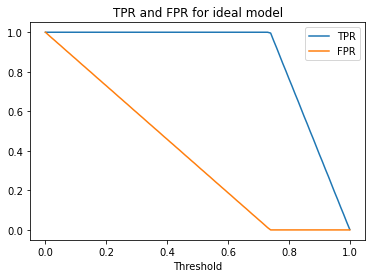

In [72]:
plt.plot(df_ideal["Threshold"], df_ideal["TPR"], label="TPR")
plt.plot(df_ideal["Threshold"], df_ideal["FPR"], label="FPR")
plt.title("TPR and FPR for ideal model")
plt.xlabel("Threshold")
plt.legend()
plt.show()

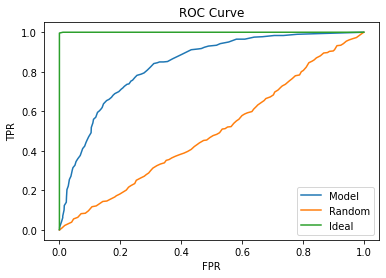

In [73]:
# ROC Curve
plt.plot(df_scores["FPR"], df_scores["TPR"], label="Model")
plt.plot(df_rand["FPR"], df_rand["TPR"], label="Random")
plt.plot(df_ideal["FPR"], df_ideal["TPR"], label="Ideal")
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

We want our model to be as close to the ideal curve as possible and as far as possible from the random curve

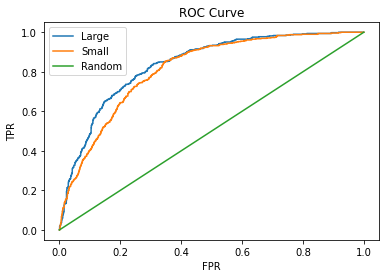

In [75]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred)
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)

plt.plot(fpr_large, tpr_large, label="Large")
plt.plot(fpr_small, tpr_small, label="Small")
plt.plot([0, 1], [0, 1], label="Random")
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

We can see that the large model is better than the small one.